## Iterative solutions of equations

Consider the following simple problem: assume we have a real valued function $f(x)$ and we would like to solve the equation 

$$ f(x) = c $$

for some constant $c$.  Let us also assume that we made a guess $f(x_0) = c$.  Of course, unless we are extremely lucky, we are not going to hit the result. So, there will be an error:

$$ f(x_0) = c + \delta $$

Now, using this error, let us improve our guess:

$$ f(x_0) - \delta = c $$

But we want $\delta$ to effect $x_0$.  Assuming we have a *local inverse* we get

$$ f^{-1}(f(x_0) - \delta) = f^{-1}(c) = a $$

where $a$ is the solution we need to find.  Now, let us write the first order Taylor approximation for the left hand side:

$$ x_0 - (f^{-1})'(x_0) \cdot \delta \approx a $$

and we know that $(f^{-1})'(x_0) = \frac{1}{f'(x_0)}$

So, our next best guess is going to be

$$ x_1 = x_0 - \frac{\delta}{f'(x_0)} $$

If we convert this formula into an iterative approximation, we get

$$ x_{n+1} = x_n - \frac{\delta_n}{f'(x_n)} $$

where $\delta_n = f(x_n) - c$

This algorithm is called [Newton-Raphson algorithm](https://en.wikipedia.org/wiki/Newton%27s_method).

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import theano
import theano.tensor as T

from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [3]:
def Solve(f, c, x0, eta=1e-2, n=10000):
    for i in range(n):
        delta = f(x0) - c
        der = (f(x0+eta/2) - f(x0-eta/2))/eta
        x1 = x0-delta/(der+eta*np.random.rand())
        if(abs(x0-x1)<eta):
            break
        else: 
            x0 = x1
    return([i,x1])

In [4]:
def fn(x):
    y = x*x
    return(1.0 + math.cos(y+0.2)+math.log(0.24+y))

In [5]:
x = Solve(fn,1.24,1.0,1e-10)
[x[0],x[1],fn(x[1])]

[8, 1.7734318154171977, 1.24]

## Multiple variable case (steepest descent)

We can develop a similar algorithm for functions with several variables. That algorithm is called [steepest descent algorithm](https://ocw.mit.edu/courses/mathematics/18-409-topics-in-theoretical-computer-science-an-algorithmists-toolkit-fall-2009/lecture-notes/MIT18_409F09_scribe21.pdf):

Given a function $F(x_1,\ldots,x_n)$ the direction in which $F$ changes the most is the gradient of $F$ which is defined as

$$ \nabla \cdot F = \left(\frac{\partial F}{\partial x_1},\ldots,\frac{\partial F}{\partial x_n}\right) $$

So, if we start with an initial guess $a^{(0)}$ for $F(a_1^{(0)},\ldots,a_n^{(0)}) = c$, the update rule is going to be

$$ a^{(m+1)} = a^{(m)} - \eta \left(\nabla\cdot F\right)(a_1^{(m)},\ldots,a_n^{(m)}) $$

where $\eta$ is called *the learning rate*.

![](images/steepest_descent.png)

(Image is taken from ["Learning-Based Auditory Encoding for Robust Speech Recognition" by Yu-Hsiang Bosco Chiu, Bhiksha Raj, and Richard M Stern](https://www.researchgate.net/figure/An-example-of-steepest-descent-optimization-steps_fig2_220655581)

In [6]:
def grad(f,x,eta=1e-4):
    def delta(i,j): 
        if(i==j): return(1) 
        else: return(0)
    def der(i,eta=1e-4):
        vec = np.array([delta(i,j) for j in range(len(x))])
        x1 = x + vec*eta/2
        x0 = x - vec*eta/2
        return((f(x1) - f(x0) + eta*np.random.rand())/eta)
    return(np.array([der(i,eta) for i in range(len(x))]))

In [7]:
def MSolve(f,c,x0,eta=1e-4,n=1000):
    for i in range(n):
        delta = f(x0) - c
        x1 = x0 - delta*eta*grad(f,x0,eta)
        err = np.linalg.norm(x1-x0)
        if(err < eta):
            break
        else:
            x0 = x1
    return([i,x1])

In [8]:
def g(x):
    y = x[0]*x[0]+x[1]*x[1]
    return(1.0+math.atan(y)+math.log(1.0+y))

MSolve(g,3.0,[0.0,0.0])

[0, array([6.31281606e-05, 5.00168448e-06])]

## The perceptron

Consider the following problem now:

Assume we have a collection of data points $(x^{(i)},y^{(i)})$ that satisfy a relationship of the form

$$ y^{(i)} - f(\alpha\cdot x^{(i)} + \beta) \sim N(0,\sigma) $$

where $f\colon\mathbb{R}\to\mathbb{R}$ is a real valued function of a single variable, $\alpha$ and $x^{(i)}$ are vectors in an inner product space and $\beta$ is a scalar.  Our task is to find the best fitting pair $(\alpha,\beta)$ such that 

$$ \sum_i (y^{(i)} - f(\alpha\cdot x^{(i)} + \beta))^2 $$

is minimized.

This is a generalization of the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) algorithm we covered in [Lecture 7](../lecture-7/lecture-7.ipynb).  In the logistic regression case $f(x) = \frac{1}{1+e^{-x}}$.

So, we proceed by an iterative update:

$$ \alpha^{(n+1)} = \alpha^{(n)} - \frac{\eta \delta^{(n)}}{f'(\alpha^{(n)}\cdot x^{(n)}+\beta^{(n)})} x^{(n)} $$

where $\delta^{(n)} = f(\alpha^{(n)}\cdot x^{(n)} + \beta^{(n)}) - y^{(n)}$

### An example



In [9]:
sonar = pd.read_csv("data/sonar.csv",sep="\t",header=None)
xs = sonar.iloc[:,0:60]
ys = sonar.iloc[:,60]

sonar.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,0
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,0
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,0
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,0
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,0


In [10]:
def diff(f,x,eta):
    return((f(x+eta/2)-f(x-eta/2))/eta)

def sigmoid(x): return(1.0/(1.0+math.exp(-x)))

In [11]:
def train(xs, ys, f, epochs, batches, eta, tol):
    n = len(xs.iloc[0,:])
    num = len(xs)
    w = np.random.rand(n+1)
    err = []
    temp = 0.0
    for i in range(epochs):
        j = np.random.randint(num)
        x = xs.iloc[j,:]
        y = ys[j]
        x0 = np.append([1],x)
        x1 = np.dot(w,x0)
        delta = f(x1) - y
        if(i%batches == batches-1):
            err.append(temp)
            temp = 0.0
        elif(abs(delta) > tol):
            temp = temp + 1.0/batches
        der = diff(f,x1,eta)+eta*np.random.rand()
        w = w - (der*delta*eta)*x0
    return(err)

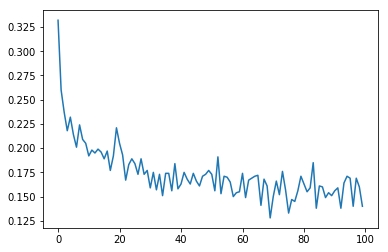

In [12]:
errors = train(xs,ys,sigmoid,100000,1000,5e-1,0.45)
plt.plot(errors)

## Neural networks

A [neural network](https://en.wikipedia.org/wiki/Artificial_neural_network) is a directed graph of perceptrons:

![](images/neural-net.png)

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network))

In this case, the weights form a sequence of matrices (a tensor) $(w^i_{j,k})$.  In the feedforward phase of the network,  where the input $(x^i_j)$ at some layer $i$ is processed by the network as

$$ x^{i+1}_k = \sum_j f^i_k(x^i_j w^i_{j,k}) $$

where $f^i_k$ is the activation function at the neuron $k$ at level $i$.

There is a very large number of different types of neural networks.  You can find a good taxonomy of such networks [here](http://www.asimovinstitute.org/neural-network-zoo/):

However, it is neither practical nor recommended that you implement neural networks by hand. 

![](images/meme.jpg)

Use one of the following libraries or frameworks:

1. [Theano](http://deeplearning.net/software/theano/)
3. [TensorFlow](https://www.tensorflow.org/)
4. [Caffe](http://caffe.berkeleyvision.org/) and [Caffe2](https://caffe2.ai/)
2. [Keras](https://keras.io/)
2. [MATLAB for Deep Learning](https://www.mathworks.com/campaigns/products/trials/targeted/dpl.html)
5. [MXNet](https://mxnet.apache.org/)
6. [The Microsoft Cognitive Toolkit](https://www.microsoft.com/en-us/cognitive-toolkit/)
8. [Deep Learning for Java](https://deeplearning4j.org/)

## Theano

Logistic regression

In [43]:
N = 400                                   
feats = 784                               

rng = np.random
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))
w = theano.shared(rng.randn(feats), name="w")
b = theano.shared(0., name="b")

x = T.dmatrix("x")
y = T.dvector("y")

p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))
prediction = p_1 > 0.5      

xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) 
cost = xent.mean() + 0.01 * (w ** 2).sum() 

gw, gb = T.grad(cost, [w, b])             
                                          
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))

training_steps = 10000
for i in range(training_steps):
    pred, err = train(D[0], D[1])

predict = theano.function(inputs=[x], outputs=prediction)
pred = predict(D[0])

In [44]:
frame = pd.DataFrame(ys,pred)
print(frame.head(20))

print("The confusion matrix is:")
confusion_matrix(ys,pred)

       60
True  NaN
False NaN
True  NaN
False NaN
True  NaN
True  NaN
True  NaN
True  NaN
False NaN
True  NaN
False NaN
True  NaN
True  NaN
False NaN
True  NaN
True  NaN
False NaN
False NaN
False NaN
True  NaN
The confusion matrix is:


ValueError: Found input variables with inconsistent numbers of samples: [208, 400]

## Keras 

A simple neural-net for binary classification:


In [38]:
model = Sequential()

model.add(Dense(1, activation='sigmoid', input_dim=60))
#model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
model.fit(xs, ys, epochs=100, batch_size=75)

Epoch 1/100
208/208 [==============================] - 0s 32us/step - loss: 0.5453 - acc: 0.7452
Epoch 2/100
208/208 [==============================] - 0s 29us/step - loss: 0.5454 - acc: 0.7404
Epoch 3/100
208/208 [==============================] - 0s 26us/step - loss: 0.5447 - acc: 0.7356
Epoch 4/100
208/208 [==============================] - 0s 28us/step - loss: 0.5439 - acc: 0.7500
Epoch 5/100
208/208 [==============================] - 0s 24us/step - loss: 0.5436 - acc: 0.7356
Epoch 6/100
208/208 [==============================] - 0s 26us/step - loss: 0.5435 - acc: 0.7356
Epoch 7/100
208/208 [==============================] - 0s 27us/step - loss: 0.5429 - acc: 0.7548
Epoch 8/100
208/208 [==============================] - 0s 48us/step - loss: 0.5423 - acc: 0.7548
Epoch 9/100
208/208 [==============================] - 0s 31us/step - loss: 0.5420 - acc: 0.7644
Epoch 10/100
208/208 [==============================] - 0s 27us/step - loss: 0.5415 - acc: 0.7548
Epoch 11/100
208/208 [=======

208/208 [==============================] - 0s 29us/step - loss: 0.5119 - acc: 0.7548
Epoch 85/100
208/208 [==============================] - 0s 35us/step - loss: 0.5119 - acc: 0.7548
Epoch 86/100
208/208 [==============================] - 0s 32us/step - loss: 0.5113 - acc: 0.7596
Epoch 87/100
208/208 [==============================] - 0s 64us/step - loss: 0.5107 - acc: 0.7548
Epoch 88/100
208/208 [==============================] - 0s 40us/step - loss: 0.5104 - acc: 0.7548
Epoch 89/100
208/208 [==============================] - 0s 29us/step - loss: 0.5104 - acc: 0.7548
Epoch 90/100
208/208 [==============================] - 0s 30us/step - loss: 0.5096 - acc: 0.7548
Epoch 91/100
208/208 [==============================] - 0s 33us/step - loss: 0.5094 - acc: 0.7644
Epoch 92/100
208/208 [==============================] - 0s 40us/step - loss: 0.5091 - acc: 0.7548
Epoch 93/100
208/208 [==============================] - 0s 38us/step - loss: 0.5088 - acc: 0.7644
Epoch 94/100
208/208 [===========

In [29]:
np.append([1,2],3)

array([1, 2, 3])